In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

facial_keypoints_detection_path = kagglehub.competition_download('facial-keypoints-detection')

print('Data source import complete.')


100%|██████████| 76.3M/76.3M [00:02<00:00, 27.1MB/s]

Extracting files...


Data source import complete.


In [3]:
facial_keypoints_detection_path

'/root/.cache/kagglehub/competitions/facial-keypoints-detection'

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(facial_keypoints_detection_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/root/.cache/kagglehub/competitions/facial-keypoints-detection/training.zip
/root/.cache/kagglehub/competitions/facial-keypoints-detection/IdLookupTable.csv
/root/.cache/kagglehub/competitions/facial-keypoints-detection/SampleSubmission.csv
/root/.cache/kagglehub/competitions/facial-keypoints-detection/test.zip


In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import v2
import math


In [6]:
# Extract training data
import zipfile
working_dir = "/content/kaggle/working/"
training_data_path = facial_keypoints_detection_path+"/training.zip"
test_data_path = facial_keypoints_detection_path+"/test.zip"
with zipfile.ZipFile(training_data_path, "r") as file:
    file.extractall(working_dir)

with zipfile.ZipFile(test_data_path, "r") as file:
    file.extractall(working_dir)

In [7]:
# Read data to dataframe
train_df = pd.read_csv(working_dir+"training.csv")
test_df = pd.read_csv(working_dir+"test.csv")

In [31]:
# Peform exploratory data analysis
# find the shape of the dataset and data type of each column
print("Shape of the dataset is", train_df.shape)
print("\nThe data types of all variables are\n", train_df.dtypes)
#print(train_df.info())

missing_vals = train_df.isnull().sum()
print("\nThe Number of NaN vals\n", missing_vals)

column_names = train_df.columns
print(column_names, len(column_names))

Shape of the dataset is (7049, 31)

The data types of all variables are
 left_eye_center_x            float64
left_eye_center_y            float64
right_eye_center_x           float64
right_eye_center_y           float64
left_eye_inner_corner_x      float64
left_eye_inner_corner_y      float64
left_eye_outer_corner_x      float64
left_eye_outer_corner_y      float64
right_eye_inner_corner_x     float64
right_eye_inner_corner_y     float64
right_eye_outer_corner_x     float64
right_eye_outer_corner_y     float64
left_eyebrow_inner_end_x     float64
left_eyebrow_inner_end_y     float64
left_eyebrow_outer_end_x     float64
left_eyebrow_outer_end_y     float64
right_eyebrow_inner_end_x    float64
right_eyebrow_inner_end_y    float64
right_eyebrow_outer_end_x    float64
right_eyebrow_outer_end_y    float64
nose_tip_x                   float64
nose_tip_y                   float64
mouth_left_corner_x          float64
mouth_left_corner_y          float64
mouth_right_corner_x         float64
mo

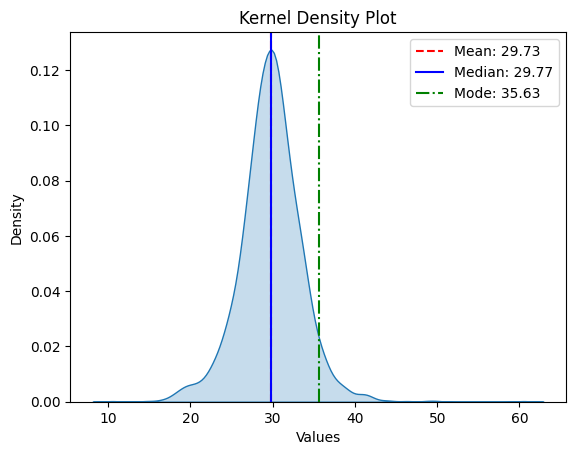

In [9]:
# There are a lot of NAN values per column, so we've got to clean that up
# well i've got to options, it is either i drop the rows that have missing values or i somewhat estimate the missing values.
# I will try several estimating techniques and see which is best for the model

# Estimating the missing values using KNN
def knn_imputer(train_df=train_df):
  from sklearn.impute import KNNImputer
  imputer = KNNImputer(n_neighbors=3)
  mod_df = train_df.drop(columns=["Image"], inplace=False)
  df_imputed = pd.DataFrame(imputer.fit_transform(mod_df), columns=mod_df.columns)
  df_imputed["Image"] = train_df["Image"]
  df_imputed.head()
  return df_imputed

def visualise_skewness(column):
  import seaborn as sns
  import matplotlib.pyplot as plt

  sns.kdeplot(column, fill=True)
  mean_value = column.mean()
  median_value = column.median()
  mode_value = column.mode()[0]
  # Add vertical lines for mean, median, and mode
  plt.axvline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
  plt.axvline(median_value, color='blue', linestyle='-', label=f'Median: {median_value:.2f}')
  plt.axvline(mode_value, color='green', linestyle='-.', label=f'Mode: {mode_value:.2f}')

  plt.xlabel('Values')
  plt.ylabel('Density')
  plt.title('Kernel Density Plot')
  plt.legend()
  plt.show()

def median_imputer(train_df=train_df):
  # decided to do a median imputer in case of skewness
  mod_df = train_df.drop(columns=["Image"], inplace=False)
  df_imputed = mod_df.fillna(mod_df.median())
  df_imputed["Image"] = train_df["Image"]
  return df_imputed

#df_imputed = knn_imputer()
visualise_skewness(train_df.iloc[:, 15])

In [26]:
train_df.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


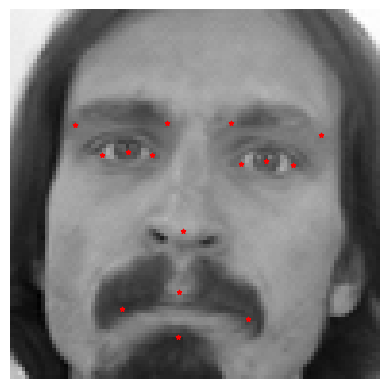

In [11]:
# Visualise image
train_df['Image'][0]
def visualize_image(df=train_df, row_idx=0, ax=None, *, image_array=None, keypoints=None):

  if ax is None:
    ax = plt.gca()


  # Convert the string to a NumPy array
  if image_array is None:
    image_string = df.at[row_idx, 'Image']
    image_array = np.array(image_string.split(), dtype=np.uint8).reshape(96, 96)

  # Extract facial keypoints
  if keypoints is None:
    keypoints = df.iloc[row_idx, 0:train_df.shape[1]-1].values.reshape(-1, 2)

  # Plot the image
  ax.imshow(image_array, cmap='gray')
  ax.scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=10, marker='*')
  ax.axis('off')

visualize_image(train_df, 0)

In [12]:
df_imputed = knn_imputer()
#df_imputed = median_imputer()

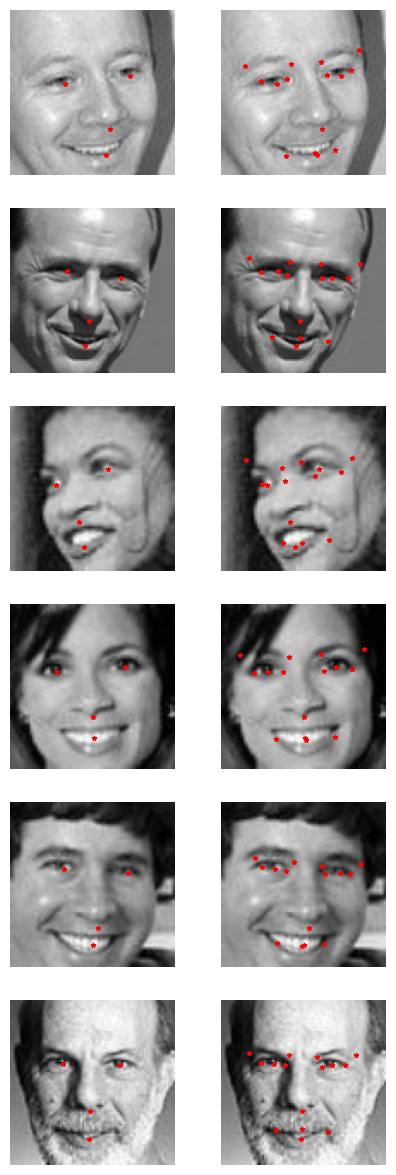

In [13]:
# Visualize the image with imputed facial features to determine whether the imputation mechanism used was effective.
np.random.seed(100)
num_samples = 6
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(5, 15))

# get the indices of rows in train_df that contain NaN values
nan_indices = train_df[train_df.isna().any(axis=1)].index

flattened_axes = axes.flatten()
# select 5 indices randomly
random_indices = np.random.choice(nan_indices, num_samples, replace=False)

# visualise randomly selected indices
for i, nan_idx in enumerate(random_indices):
  visualize_image(train_df, nan_idx, ax=flattened_axes[2 * i])

  visualize_image(df_imputed, nan_idx, ax=flattened_axes[2*i + 1])

In [14]:
class FacialkeypointsDataset(torch.utils.data.Dataset):
  def __init__(self, df:pd.DataFrame, transform=None):
    self.df = df
    self.transform = transform
    self.image_size = (96, 96)
    self.keypoints_col = self.df.columns.drop('Image')

  def __getitem__(self, index):
     sample = self.df.iloc[index]

     # Convert the space-separated string into a NumPy array and reshape it.
     image_str = sample['Image']
     image_array = np.array(image_str.split(), dtype=np.uint8)
     image_array = image_array.reshape(*self.image_size)

     keypoints = sample[self.keypoints_col].values.astype(np.float32)

     if self.transform:
       image_array = self.transform(image_array)

     return image_array, keypoints

  def __len__(self):
    return len(self.df)


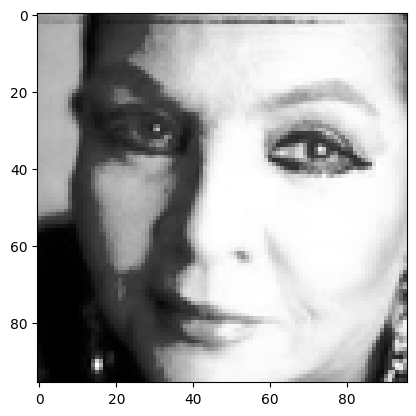

In [15]:
# set transforms
transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

# load data from file
data = FacialkeypointsDataset(df_imputed, transform=transforms)

# split data
trainset, testset = torch.utils.data.random_split(data, [0.8, 0.2], generator=torch.Generator().manual_seed(180))

# create datalodaers
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testLoader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

plt.imshow(next(iter(trainloader))[0][0].squeeze(), cmap='gray')

In [ ]:
type(testset.indices)

list

In [16]:
# create conv net
class FacialkeypointConvNet(nn.Module):
  def __init__(self):
    super().__init__()

    # input image size is (96 x 96)
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=1) # [32 x 94 x 94]
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3) # [64 x 92 x 92]
    self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2) # [64 x 46 x 46]

    self.conv3 = nn.Conv2d(64, 128, kernel_size=3) # [128 x 44 x 44]
    self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2) # [128 x 22 x 22]

    self.conv4 = nn.Conv2d(128, 256, kernel_size=3) # [256 x 20 x 20]
    self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2) # [256 x 10 x 10]

    # fully connected layer
    self.fc1 = nn.Linear(256*10*10, 2048)
    self.fc2 = nn.Linear(2048, 1024)
    self.fc3 = nn.Linear(1024, 256)
    self.fc4 = nn.Linear(256, 30)

    self.dropout = nn.Dropout(p=0.5)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.maxpool1(x)

    x = F.relu(self.conv3(x))
    x = self.maxpool2(x)

    x = F.relu(self.conv4(x))
    x = self.maxpool3(x)

    x = x.view(x.size(0), -1)

    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = F.relu(self.fc2(x))
    x = self.dropout(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)

    return x

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [18]:
model = FacialkeypointConvNet()
model.to(device)

FacialkeypointConvNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=2048, bias=True)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=30, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold=0.01, min_lr=0.0001)

In [ ]:
epochs = 50

for epoch in range(epochs):
  running_loss = 0.0
  batch  = 0
  for input, label in trainloader:
    batch += 1
    optimizer.zero_grad()
    input, label = input.to(device), label.to(device)
    output = model(input)
    #print(output.shape, label.shape)
    loss = criterion(output, label)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    if batch % 30 == 0 or batch == len(trainloader):
      pass
      #print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, RMSE: {math.sqrt(loss.item())}")
  mse_loss = running_loss / len(trainloader)
  scheduler.step(math.sqrt(mse_loss))

  print(f"Epoch {epoch+1}/{epochs}, Loss: {mse_loss}, RMSE: {math.sqrt(mse_loss)} LR: {optimizer.param_groups[0]['lr']}")



Epoch 1/10, Loss: 20.55447256431151, RMSE: 4.533704066688904 LR: 0.000125
Epoch 2/10, Loss: 20.881632311960285, RMSE: 4.569642470911733 LR: 0.000125
Epoch 3/10, Loss: 20.624680572681214, RMSE: 4.5414403632197144 LR: 0.000125
Epoch 4/10, Loss: 20.219939435465953, RMSE: 4.496658696795428 LR: 0.000125
Epoch 5/10, Loss: 20.604315639881605, RMSE: 4.53919768680343 LR: 0.0001
Epoch 6/10, Loss: 20.79064485999975, RMSE: 4.559675959977831 LR: 0.0001
Epoch 7/10, Loss: 20.53936178228828, RMSE: 4.532037266206919 LR: 0.0001
Epoch 8/10, Loss: 20.76505935326051, RMSE: 4.556869468534348 LR: 0.0001
Epoch 9/10, Loss: 20.50054059403666, RMSE: 4.527752267299599 LR: 0.0001
Epoch 10/10, Loss: 20.316938239536928, RMSE: 4.507431445905409 LR: 0.0001


In [ ]:
model.train()
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            #'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, working_dir + 'model.pth')

In [25]:
saved_dict = torch.load(working_dir+'model.pth')
model.load_state_dict(saved_dict['model_state_dict'])

<All keys matched successfully>

In [23]:
test_loss = 0.0
model.eval()
with torch.no_grad():
  for images, labels in testLoader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
  mse_loss = test_loss / len(testLoader)
  print(f"Test Loss RMSE: {math.sqrt(mse_loss)}")

Test Loss RMSE: 3.6002279239410666


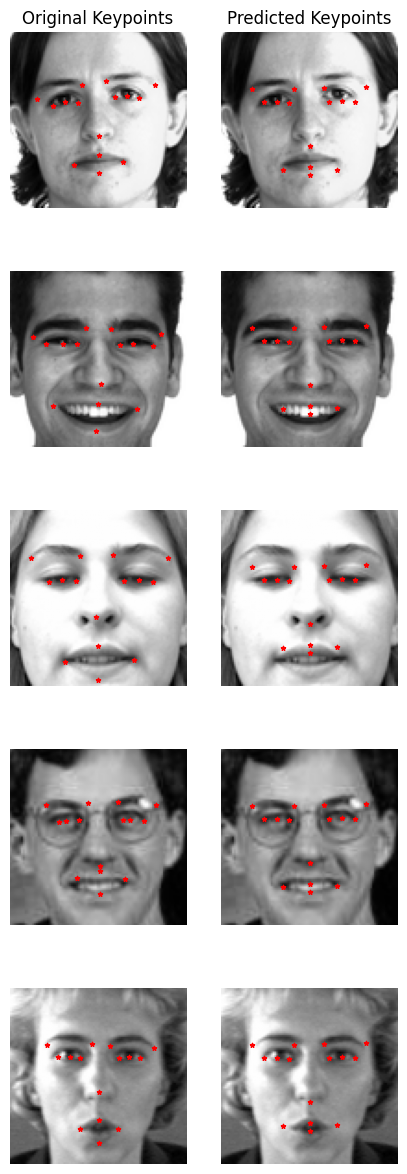

In [30]:
# Make inference
import random

model.eval()
num_samples = 5
rand_indices = random.sample(testset.indices, k=num_samples)
fig, axes = plt.subplots(nrows=num_samples, ncols=2, figsize=(5, 15))
# Set the column titles
column_titles = ['Original Keypoints', 'Predicted Keypoints']
for ax, col_title in zip(axes[0], column_titles):
    ax.set_title(col_title, fontsize='large')

flattened_axes = axes.flatten()

for i, idx in enumerate(rand_indices):
  visualize_image(df_imputed, idx, ax=flattened_axes[2 * i])
  with torch.no_grad():
    image = data[idx][0].to(device)
    output = model(image.unsqueeze(0))
    visualize_image(ax=flattened_axes[2*i + 1], image_array=image.squeeze().cpu(), keypoints=output.reshape(-1, 2).cpu())


In [44]:
# Initialize a list to store the results
results = []

model.eval()

for row in test_df.itertuples(index=False):
  with torch.no_grad():
    image_array = np.array(row.Image.split(), dtype=np.uint8)
    image_array = image_array.reshape(96, 96)
    image = transforms(image_array)
    image = image.to(device)
    output = model(image.unsqueeze(0))

    for i, location in enumerate(output.squeeze()):
      feature_name = train_df.columns[i]
      results.append({"ImageId":row.ImageId, "FeatureName":feature_name, "Location": location.item()})

# Convert to DataFrame
df_output = pd.DataFrame(results)
print(df_output.head())


   ImageId              FeatureName   Location
0        1        left_eye_center_x  65.302933
1        1        left_eye_center_y  37.070869
2        1       right_eye_center_x  29.832949
3        1       right_eye_center_y  37.696205
4        1  left_eye_inner_corner_x  58.291691


In [45]:
import pandas as pd

lookup_df = pd.read_csv("/root/.cache/kagglehub/competitions/facial-keypoints-detection/IdLookupTable.csv")
print(lookup_df.head())

   RowId  ImageId              FeatureName  Location
0      1        1        left_eye_center_x       NaN
1      2        1        left_eye_center_y       NaN
2      3        1       right_eye_center_x       NaN
3      4        1       right_eye_center_y       NaN
4      5        1  left_eye_inner_corner_x       NaN


In [50]:
updated_lookup = lookup_df.drop(columns=['Location']).merge(
    df_output, on=['ImageId', 'FeatureName'], how='left'
)
# The merged result contains the correct RowId and predicted Location
updated_lookup = updated_lookup[['RowId', 'Location']]  # Keep only submission columns

# Save to CSV
updated_lookup.to_csv("submission.csv", index=False)